In [499]:
#Import chunk


import numpy as np

import math

import struct

import random

import time

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [500]:
def tanh(x):
    return np.tanh(x)

def softmax(x):
    #这里减去x.max()为了防止指数爆炸，并不会影响结果
    exp=np.exp(x-x.max())
    return exp/exp.sum()

In [501]:
#Initial chunk

#两层的维度
dimension=[784,100,10]
#两层的激活函数
activation=[tanh,softmax]




# distribution=[
#     {'b':[0,0],'w':[1,1]},
#     {'b':[0,0],'w':[1,1]}
# ]



distribution=[
    {'b':[0,0],'w':[-math.sqrt(6/(dimension[0]+dimension[-1])),math.sqrt(6/(dimension[0]+dimension[-1]))]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimension[0]+dimension[-1])),math.sqrt(6/(dimension[0]+dimension[-1]))]}
]



In [502]:
#Parameter's initial


def init_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimension[layer+1])*(dist[1]-dist[0])+dist[0]


def init_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimension[layer],dimension[layer+1])*(dist[1]-dist[0])+dist[0]

def init_wb():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='w':
                layer_parameter['w']=init_w(i)
            elif j=='b':
                layer_parameter['b']=init_b(i)
        parameter.append(layer_parameter)
    return parameter

In [503]:
parameters=init_wb()

In [504]:
for i in range(len(parameters)):
    print('{}层:'.format(i))
    for j in parameters[i].keys():
        print(j)
        print(parameters[i][j].shape)

0层:
b
(100,)
w
(784, 100)
1层:
b
(10,)
w
(100, 10)


In [505]:
predict(train_image[0],parameters)

array([0.11876442, 0.08695954, 0.10370086, 0.12258537, 0.12762254,
       0.09231237, 0.09015967, 0.11223493, 0.07913351, 0.06652678])

In [506]:
data_path='./datas/'

train_image_path=data_path+'train-images.idx3-ubyte'
train_label_path=data_path+'train-labels.idx1-ubyte'

test_image_path=data_path+'t10k-images.idx3-ubyte'
test_label_path=data_path+'t10k-labels.idx1-ubyte'


In [507]:
train_num=50000
validate_num=10000
test_num=10000

with open(train_image_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tem_image=np.fromfile(f,dtype=np.uint8).reshape(-1,784)/255
    train_image=tem_image[:train_num]
    validate_image=tem_image[train_num:]
    
with open(test_image_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_image=np.fromfile(f,dtype=np.uint8).reshape(-1,784)/255
    

with open(train_label_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tem_label=np.fromfile(f,dtype=np.uint8)
    train_label=tem_label[:train_num]
    validate_label=tem_label[train_num:]

with open(test_label_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_label=np.fromfile(f,dtype=np.uint8)    
    

In [508]:
def show_train(index):
    print('label:'+str(train_label[index]))
    a_image=train_image[index].reshape(-1,28)
    plt.imshow(a_image,cmap='gray')
    
    
def show_validate(index):
    print('label:'+str(validate_label[index]))
    a_image=validate_image[index].reshape(-1,28)
    plt.imshow(a_image,cmap='gray')
    
    
def show_test(index):
    print('label:'+str(test_label[index]))
    a_image=test_image[index].reshape(-1,28)
    plt.imshow(a_image,cmap='gray')

In [509]:
def predict(image,parameters):
    hidden=activation[0](np.dot(image,parameters[0]['w'])+parameters[0]['b'])
    output=activation[1](np.dot(hidden,parameters[1]['w'])+parameters[1]['b'])
    return output

In [510]:
label_keys=np.identity(dimension[-1])


In [511]:
def loss(image,label,parameters):
    y_predict=predict(image,parameters)
    y_label=label_keys[label]
    difference=y_predict-y_label
    return np.dot(difference,difference)

In [512]:
#loss(train_image[0],train_label[0],parameters)

In [513]:
def validate_verify(parameters):
    error_num=0
    for i in range(validate_num):
        
        if predict(validate_image[i],parameters).argmax()!=validate_label[i]:
        
            error_num+=1
            
    rate=1-error_num/validate_num
    #print('验证集准确率：'+str(rate*100)+'%')
    return rate
    

In [514]:
#validate_verify(parameters)

In [515]:
def init_zero_grad():
    parameter=[]
    for layer in range(len(distribution)):
        layer_parameter={}
        for j in distribution[layer].keys():
            if j=='w':
                layer_parameter['w']=np.zeros((dimension[layer],dimension[layer+1]))
            elif j=='b':
                layer_parameter['b']=np.zeros(dimension[layer+1])
        parameter.append(layer_parameter)
    return parameter

In [549]:
def calculate_a_grad(image,label):
    
    l0=np.dot(image,parameters[0]['w'])+parameters[0]['b']
    h=activation[0](l0)
    
    l2=np.dot(h,parameters[1]['w'])+parameters[1]['b']
    l3=activation[1](l2)
    #
    #print(l3)
    a_grad=[{},{}]
    d_L_l3=2*(l3-label_keys[label])
    d_l3_l2=np.diag(l3)-np.outer(l3,l3)
    
    a_grad[1]['b']=np.dot(d_L_l3,d_l3_l2)
    a_grad[1]['w']=np.outer(h,a_grad[1]['b'])   
    d_L_h=np.dot(parameters[1]['w'],a_grad[1]['b'])
    a_grad[0]['b']=(1-np.tanh(l0)**2)*d_L_h
    a_grad[0]['w']=np.outer(image,a_grad[0]['b'])
    
    return a_grad
            
            

In [550]:
banch_num=100
def calculate_banch_grad(banch_time):
    
    banch_grad=init_zero_grad()
    for i in range(banch_num*banch_time,banch_num*(banch_time+1)):
        
        #print('训练'+str(i+1)+'/'+str(banch_num)+'个参数')
        tem_grad=calculate_a_grad(train_image[i],train_label[i])
        for j in range(len(banch_grad)):
            for k in banch_grad[j].keys():
                banch_grad[j][k]+=tem_grad[j][k]
    for j in range(len(banch_grad)):
        for k in banch_grad[j].keys():
            banch_grad[j][k]/=banch_num
    
    
    return banch_grad           

In [551]:
parameters=init_wb()
validate_verify(parameters)

0.047699999999999965

In [552]:
def train_banch(banch_grad,learn_rate):
    #print('正在修正参数')
    for j in range(len(banch_grad)):
        for k in banch_grad[j].keys():
            parameters[j][k]-=learn_rate*banch_grad[j][k]
            
            

In [553]:
learn_rate=1
def train():
    
    for i in (range(train_num//banch_num)):
        time0=time.time()
        #print('#===============开始训练第'+str(i+1)+'/'+str(train_num//banch_num)+'组==============#')
        banch_grad=calculate_banch_grad(i)
        train_banch(banch_grad,learn_rate)
        time1=time.time()
        #print('当前组用时：{}s'.format(time1-time0))
        #validate_verify(parameters)
    #print('Train Over!')
    
    

In [554]:
parameters=init_wb()
validate_verify(parameters)

0.1139

In [555]:
epoch=[]

In [558]:
tem_time0=time.time()
epoch_num=1
for i in tqdm_notebook(range(epoch_num)):
    train()
    epoch.append(validate_verify(parameters))
tem_time1=time.time()

print('总用时：{}'.format(tem_time1-tem_time0))


总用时：22.79621171951294


In [487]:
tem_epoch=[i*100 for i in epoch] 

In [546]:
validate_verify(parameters)

0.9367

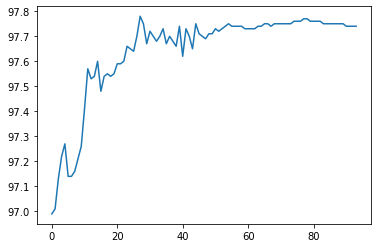

In [534]:
l=
r=-1
plt.plot(tem_epoch[l:r])

In [480]:
epoch

[0.9359,
 0.9545,
 0.9604,
 0.9657,
 0.9695,
 0.9703,
 0.9699,
 0.9701,
 0.9713,
 0.9722,
 0.9727,
 0.9714,
 0.9714,
 0.9716,
 0.9721,
 0.9726,
 0.9741,
 0.9757,
 0.9753000000000001,
 0.9754,
 0.976,
 0.9748,
 0.9754,
 0.9755,
 0.9754,
 0.9755,
 0.9759,
 0.9759,
 0.976,
 0.9766,
 0.9765,
 0.9764,
 0.977,
 0.9778,
 0.9775,
 0.9767,
 0.9772,
 0.977,
 0.9768,
 0.977,
 0.9773,
 0.9767,
 0.977,
 0.9768,
 0.9766,
 0.9774,
 0.9762,
 0.9773,
 0.977,
 0.9765,
 0.9775]

In [383]:
#训练前77组(每组500个数据)数据后
validate_verify(parameters)

0.09909999999999997

In [113]:
#parameters

In [102]:
#训练前85组(每组500个数据)数据后
validate_verify(parameters)

准确率：14.470000000000006%


In [464]:
#训练前89组(每组500个数据)数据后
validate_verify(parameters)

准确率：72.44%


In [112]:
print(parameters[0]['w'].shape,
parameters[0]['b'].shape,
parameters[1]['w'].shape,
parameters[1]['b'].shape)


(784, 100) (100,) (100, 10) (10,)


In [109]:
print(parameters[1]['w'][:10][:1])

[[ 0.15203301  0.20998929 -0.15912345  0.00269307 -0.0345071  -0.03045856
  -0.05981318  0.02818692 -0.20990824 -0.2315964 ]]


In [306]:
#Validate gradient 

step=0.0001

def validate_grad(image,label):
    
    l0=image+parameters[0]['b']
    
    h=activation[0](l0)
    
    l2=np.dot(h,parameters[1]['w'])+parameters[1]['b']
    
    l3=activation[1](l2)
    
    exp_l2=np.exp(l2)
    
    
   
    
    zero_grad=init_zero_grad()
    
    for ii in range(len(zero_grad)):
        for jj in zero_grad[ii].keys():
            zero_grad[ii][jj]=zero_grad[ii][jj]+parameters[ii][jj]

            
    loss0=loss(image,label,parameters)
    #验证w1参数
    for i in range(784):
        
        for j in range(10):  
            
            zero_grad=init_zero_grad()
            for ii in range(len(zero_grad)):
                for jj in zero_grad[ii].keys():
                    zero_grad[ii][jj]=zero_grad[ii][jj]+parameters[ii][jj]

            
            zero_grad[1]['w'][i][j]=zero_grad[1]['w'][i][j]+step
            loss1=loss(image,label,zero_grad)
            
            #print('loss0='+str(loss0))
            #print('loss1='+str(loss1))
            
            calc_grid=0
            
            tem=0
            
            for k in range(10):
                
                if j==k:
                    tem=(softmax(l2)[j]-(softmax(l2)[j])**2)
                else:
                    tem=(-softmax(l2)[j]*softmax(l2)[k])
                
                #print('Rem1:tem='+str(tem))
                tem=tem*2*(l3[k]-label_keys[label][k])*h[i]
                #print('Rem2:tem='+str(tem))
                calc_grid=calc_grid+tem
            print('w1'+str([i])+str([j]),end='')
            print('计算梯度为：'+str(calc_grid),end='')
            print('差商梯度为：'+str((loss1-loss0)/step))
    
#validate_grad(train_image[0],train_label[0])



In [283]:
def test_grad_correct():
    step=0.0001

    test_input=np.random.rand(4)
    print(test_input)
    v0=softmax(test_input)
    print(v0)

    test_grad=[]
    test_input_exp=np.exp(test_input-test_input.max())
    test_input_exp_sum=test_input_exp.sum()
    
    
    
    for i in range(4):
        if i==1:
            test_grad.append(test_input_exp[i]/test_input_exp_sum-(test_input_exp[i]/test_input_exp_sum)**2)
        else:
            test_grad.append(-test_input_exp[i]*test_input_exp[1]/(test_input_exp_sum**2))
    


    test_input[1]=test_input[1]+step
    v1=softmax(test_input)
    print(v1)
    print('差商：'+str((v1-v0)/step))
    print('梯度：'+str(test_grad))

    
test_grad_correct()


[0.43768751 0.38216954 0.4549189  0.15676711]
[0.26892823 0.25440477 0.2736024  0.2030646 ]
[0.26892139 0.25442374 0.27359544 0.20305943]
差商：[-0.06841831  0.18968764 -0.06960746 -0.05166187]
梯度：[-0.06841662539087341, 0.18968298322494734, -0.06960575502513042, -0.05166060280894351]


In [344]:
with open('111.txt','w') as f:
    f.write(str(parameters[0]['b'])+'\n')
    f.write(str(parameters[1]['b'])+'\n')
    f.write(str(parameters[1]['w'])+'\n')

In [494]:


def write_parameters():

    f=open('111.txt','w')
    
    
    
    
    f.write('第1层：\n')
    f.write('b:\n')
    for i in parameters[0]['b']:
        f.write(str(i)+'\t')
    f.write('\n第2层：\n')
    f.write('b:\n')
    for i in parameters[1]['b']:
        f.write(str(i)+'\t')
    f.write('\nw:\n')
    for i in parameters[1]['w']:
        for j in i:
            f.write(str(j)+'\t')
        f.write('\n')
    f.write('\n')
    f.close()
write_parameters()    

预测序号：22691
我的预测：0
label:0


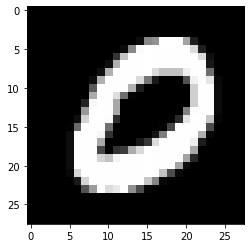

In [458]:
def rrrr(index):
    print('预测序号：{}'.format(index))
    print('我的预测：{}'.format(predict(train_image[index],parameters).argmax()))
    show_train(index)
rrrr(random.randint(0,50000))